/Users/vvv/opt/anaconda3/envs/pml/lib/python3.8/site-packages/probml_utils-0.0.0-py3.8.egg/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/Users/vvv/opt/anaconda3/envs/pml/lib/python3.8/site-packages/probml_utils-0.0.0-py3.8.egg/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


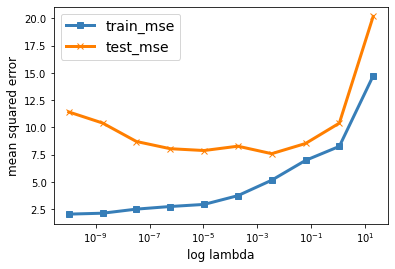

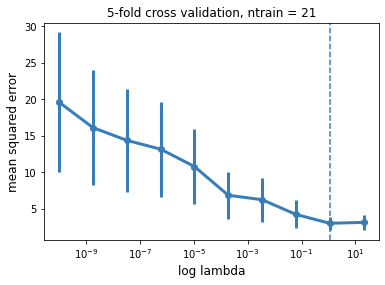

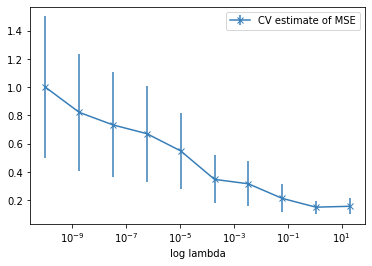

In [1]:

import numpy as np
import math
try:
    from cycler import cycler
except ModuleNotFoundError:
    %pip install -qq cycler
    from cycler import cycler
try:
    from sklearn.model_selection import cross_val_score
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, make_scorer
from matplotlib import pyplot as plt
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

np.random.seed(0)

# Using Colorblind friendly colors

cb_color = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]

cb_cycler = cycler(linestyle=["-", "--", "-."]) * cycler(color=cb_color)
plt.rc("axes", prop_cycle=cb_cycler)


def func(x, w):
    return w[0] * x + w[1] * np.square(x)


# 'Data as mentioned in the matlab code'
def polydatemake():
    n = 21
    sigma2 = 4
    xtrain = np.linspace(0, 20, n)
    xtest = np.arange(0, 20.1, 0.1)
    w = np.array([-1.5, 1 / 9])
    ytrain = func(xtrain, w).reshape(-1, 1) + math.sqrt(sigma2) * np.random.randn(
        xtrain.shape[0], 1
    )
    ytest_noisefree = func(xtest, w).reshape(-1, 1)
    ytest_noisy = ytest_noisefree + math.sqrt(sigma2) * np.random.randn(
        xtest.shape[0], 1
    )

    return xtrain, ytrain, xtest, ytest_noisefree, ytest_noisy, sigma2


def rescale(X):
    scaler = MinMaxScaler((-1, 1))
    return scaler.fit_transform(X.reshape(-1, 1))


def poly_features(X, deg):
    X_deg = np.tile(X, deg)
    n_deg = np.arange(14) + 1
    degs = np.tile(np.repeat(n_deg, X.shape[1]), X.shape[0]).reshape(X.shape[0], -1)
    X_poly = np.power(X_deg, degs)

    return X_poly


# Not used, wrote it,as to use if needed.
def addones(X):
    # x is of shape (s,)
    return np.insert(X[:, np.newaxis], 0, [[1]], axis=1)


[xtrain, ytrain, xtest, ytest_noisefree, ytest, sigma2] = polydatemake()

deg = 14

poly_train = poly_features(rescale(xtrain), deg)
poly_test = poly_features(rescale(xtest), deg)

ytrain = ytrain - ytrain.mean()
ytest = ytest - ytest.mean()

# -------------------------------------------
# error vs lambda
#lambdas = np.logspace(-10, 2.5, 15)

# match lireng_poly_ridge

lambdas = np.logspace(-10, 1.3, 10)
train_mse, test_mse = [], []

for lam in lambdas:
    reg = linear_model.Ridge(alpha=lam, fit_intercept=False).fit(poly_train, ytrain)
    ypred_train = reg.predict(poly_train)
    ypred_test = reg.predict(poly_test)
    train_mse.append(((ypred_train - ytrain) ** 2).mean())
    test_mse.append(((ypred_test - ytest) ** 2).mean())

plt.figure()
plt.semilogx(lambdas, train_mse, "-s", lw=3)
plt.semilogx(lambdas, test_mse, "-x", lw=3)
plt.legend(["train_mse", "test_mse"],  fontsize=14)
plt.xlabel("log lambda", fontsize=12)
plt.ylabel("mean squared error",  fontsize=12)
pml.savefig("polyfitRidgeUcurve.pdf")

# -------------------------------------------
# cv vs lambda
cv_means = []
cv_stand_errors = []
n= len(xtrain)
n_folds = 5
scorer = make_scorer(mean_squared_error, greater_is_better=False)
for lam in lambdas:
    cross_validations = -np.array(
        cross_val_score(
            linear_model.Ridge(alpha=lam, fit_intercept=False),
            poly_train,
            ytrain,
            cv=n_folds,
            scoring=scorer,
        )
    )
    cv_means.append(cross_validations.mean())
    cv_stand_errors.append(cross_validations.std() / np.sqrt(n_folds))

plt.figure()
plt.errorbar(
    lambdas, np.log(cv_means), yerr=np.log(np.array(cv_stand_errors)) / 2, lw=3, fmt="-o"
)
plt.title("{}-fold cross validation, ntrain = {}".format(n_folds, poly_train.shape[0]), fontsize=12)
plt.axvline(
    lambdas[np.argmin(cv_means)], ls="--"
)  # lambda corresponding to minimum cv_mean.
plt.xscale("log")
plt.xlabel("log lambda", fontsize=12)
plt.ylabel("mean squared error", fontsize=12)
pml.savefig("polyfitRidgeCV.pdf")


plt.figure()
cvErr = np.log(cv_means) / np.max(np.log(cv_means))
cv_se = np.log(cv_stand_errors) / np.max(np.log(cv_stand_errors))
plt.errorbar(lambdas, cvErr, yerr=cv_se / 2, fmt="-x")
plt.xlabel("log lambda")
plt.xscale("log")
plt.legend(["CV estimate of MSE"])
plt.show()
